<a href="https://colab.research.google.com/github/elhamshaerirahbar-bot/my-colab-project/blob/main/Untitled13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install numpy pandas tensorflow

In [3]:
import numpy as np, pandas as pd, re, unicodedata
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import tensorflow as tf
from tensorflow.keras import layers, callbacks
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import mean_absolute_percentage_error

In [4]:
import pandas as pd, re, unicodedata
from difflib import get_close_matches

WANTED = ['factor A','factor B','factor C','factor D','Response 2 (Mw)', 'Response 1 (Mn)']

def norm(s: str) -> str:
    s = unicodedata.normalize("NFKC", str(s))
    s = s.replace("\ufeff","").replace("\u00a0"," ")
    s = re.sub(r"\s+"," ", s).strip()
    return s.lower()

df = pd.read_csv('Exp_Mn_Mw_Value.txt', sep='\t')


name_map = {norm(c): c for c in df.columns}

def map_col(wanted: str):
    k = norm(wanted)
    if k in name_map:
        return name_map[k]

    cand = get_close_matches(k, list(name_map.keys()), n=1, cutoff=0.7)
    return name_map[cand[0]] if cand else None

mapped = [(w, map_col(w)) for w in WANTED]
missing = [w for w,c in mapped if c is None]
cols    = [c for _,c in mapped if c is not None]

print(f"Missing: {missing}")

n = 5
view = df[cols].head(n)
try:
    display(view)
except NameError:
    print(view.to_string(index=False))

Missing: []


,Factor A,Factor B,Factor C,Factor D,Response 2 (Experimental),Response 1 (Experimental)
0,110,7,50,10,1321.65,1127.19
1,85,13,50,10,1339.35,1024.97
2,101,1,500,60,2878.90,1950.00
3,101,1,500,60,2989.00,2223.17
4,50,10,50,10,2690.50,1845.60


In [5]:
# ---- pick columns via your map_col ----
FEATURES = [map_col('factor A'), map_col('factor B'),
            map_col('factor C'), map_col('factor D')]

TARGETS  = [map_col('Response 1 (Mn)'), map_col('Response 2 (Mw)')]  # دو خروجی

X = df[FEATURES].astype(float).to_numpy()   # shape: (n, 4)
y = df[TARGETS].astype(float).to_numpy()    # shape: (n, 2)

print("X:", X.shape, " y:", y.shape)

X: (25, 4)  y: (25, 2)


In [6]:
from sklearn.model_selection import train_test_split
import numpy as np

# X: (n, 4), y: (n, 2)  -> z.B. y = df[['Response 1 (Mn)','Response 2 (Mw)']].to_numpy()
SEED = 55

# 1) 20% Test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.35, shuffle=True, random_state=SEED
)
# 2) 20% von Train für Val  -> insgesamt: Train 64%, Val 16%, Test 20%
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.35, shuffle=True, random_state=SEED
)

print(X_train.shape, X_val.shape, X_test.shape)  # Kontrolle
print(y_train.shape, y_val.shape, y_test.shape)

(10, 4) (6, 4) (9, 4)
(10, 2) (6, 2) (9, 2)


In [7]:
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# X: (n,4), y: (n,2)  -> z.B. y[:,0]=Mn, y[:,1]=Mw
assert y_train.ndim == 2 and y_train.shape[1] == 2, "y muss (n,2) sein"

# --- X skalieren (nur auf Train fitten) ---
x_scaler = StandardScaler().fit(X_train)
X_train_z = x_scaler.transform(X_train)
X_val_z   = x_scaler.transform(X_val)
X_test_z  = x_scaler.transform(X_test)

# --- y skalieren (für tanh: [-1,1]) -> spaltenweise, automatisch ---
y_scaler  = MinMaxScaler(feature_range=(-1, 1)).fit(y_train)  # y_train: (n,2)
y_train_s = y_scaler.transform(y_train)
y_val_s   = y_scaler.transform(y_val)
y_test_s  = y_scaler.transform(y_test)

def inv_y(y_s):
    """Skalierung der Targets rückgängig machen -> echte Einheiten (Mn, Mw)."""
    return y_scaler.inverse_transform(y_s)

In [8]:
ann = tf.keras.models.Sequential()

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from tensorflow.keras import layers, regularizers, callbacks

# Annahmen:
# X_train_z, X_val_z, X_test_z = standardisierte Features
# y_train_s, y_val_s, y_test_s = MinMax(-1,1) skalierte Targets, Form (n, 2)
# inv_y(...)  -> macht die Skalierung von y rückgängig (zurück in echte Einheiten)

assert y_train_s.ndim == 2 and y_train_s.shape[1] == 2, "y muss (n,2) sein!"

model = Sequential([
    layers.Dense(16, activation='relu',
                 kernel_regularizer=regularizers.l2(1e-5),
                 input_shape=(X_train_z.shape[1],)),
    Dropout(0.1),
        layers.Dense(8, activation='relu', kernel_regularizer=regularizers.l2(1e-5)),
    Dropout(0.1),
        layers.Dense(8, activation='relu', kernel_regularizer=regularizers.l2(1e-5)),
    Dropout(0.1),
    layers.Dense(2, activation='tanh')
])

model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mape'])

C:\Users\brian\PycharmProjects\PythonProject1\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mape'])

early = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)

history = model.fit(
    X_train_z, y_train_s,
    validation_data=(X_val_z, y_val_s),
    epochs=500, batch_size=16, verbose=1, callbacks=[early]
)

Epoch 1/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.3325 - mae: 0.4554 - mape: 150.3302 - val_loss: 0.1860 - val_mae: 0.3279 - val_mape: 133.2568
Epoch 2/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.2985 - mae: 0.4136 - mape: 111.3289 - val_loss: 0.1847 - val_mae: 0.3261 - val_mape: 132.1751
Epoch 3/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.2891 - mae: 0.3982 - mape: 115.8785 - val_loss: 0.1838 - val_mae: 0.3245 - val_mape: 131.2116
Epoch 4/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.3517 - mae: 0.4688 - mape: 127.0685 - val_loss: 0.1827 - val_mae: 0.3229 - val_mape: 130.5898
Epoch 5/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.3128 - mae: 0.4151 - mape: 109.0199 - val_loss: 0.1817 - val_mae: 0.3214 - val_mape: 129.8776
Epoch 6/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.3081 - mae: 0.4312 - mape: 142.6118 - val_loss: 0.1805 - val_mae: 0.3199 - val_mape: 129.2465
Epoch 7/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.3599 - mae: 0.4612

In [12]:
#Vorhersagen (zuerst im skalierten Raum, dann zurück in echte Einheiten)
y_hat_train_s = model.predict(X_train_z, verbose=1)
y_hat_val_s   = model.predict(X_val_z,   verbose=1)
y_hat_test_s  = model.predict(X_test_z,  verbose=1)

y_hat_train = inv_y(y_hat_train_s)
y_hat_val   = inv_y(y_hat_val_s)
y_hat_test  = inv_y(y_hat_test_s)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

def report_2out(name, yt, yp, labels=("Mn", "Mw")):
    # yt و yp باید (n,2) باشن
    for i, label in enumerate(labels):
        y_true = yt[:, i].reshape(-1)
        y_pred = yp[:, i].reshape(-1)

        mae  = mean_absolute_error(y_true, y_pred)
        mse  = mean_squared_error(y_true, y_pred)
        r2   = r2_score(y_true, y_pred)
        mape = mean_absolute_percentage_error(y_true, y_pred)

        print(f"[{name}] {label}: MAE={mae:.6f}  MSE={mse:.6f}  R²={r2:.4f}  MAPE={mape:.6f}")

In [14]:
report_2out("Train", y_train, y_hat_train)
report_2out("Val  ", y_val,   y_hat_val)
report_2out("Test ", y_test,  y_hat_test)

[Train] Mn: MAE=418.815694  MSE=454503.787176  R²=0.6523  MAPE=0.127492
[Train] Mw: MAE=561.508452  MSE=799189.338028  R²=0.6257  MAPE=0.127961
[Val  ] Mn: MAE=369.988094  MSE=318464.849942  R²=0.1809  MAPE=0.146121
[Val  ] Mw: MAE=529.929165  MSE=846812.767161  R²=0.2107  MAPE=0.121886
[Test ] Mn: MAE=408.749437  MSE=289768.203487  R²=0.4381  MAPE=0.179023
[Test ] Mw: MAE=516.897972  MSE=640635.927017  R²=0.5489  MAPE=0.148113


In [15]:
!pip install matplotlib

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
import numpy as np, pandas as pd

def make_table_multi(split, y_true, y_pred, target_names=("Mn","Mw"), n=None):
    """
    Baut eine Tabelle für 2 (oder mehr) Outputs.
    y_true, y_pred: Form (n, k)  -> k = Anzahl Outputs (hier 2: Mn, Mw)
    pct_error in Prozent (0–100). Für Anteil (0–1) unten scale=1 nutzen.
    """
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    assert y_true.shape == y_pred.shape and y_true.ndim == 2, "y muss (n,k) sein"
    k = y_true.shape[1]
    assert k == len(target_names), "target_names-Länge passt nicht zu y.shape[1]"

    parts = []
    for j, name in enumerate(target_names):
        df = pd.DataFrame({
            "split":     split,
            "target":    name,
            "actual":    y_true[:, j],
            "predicted": y_pred[:, j],
        })
        df["residual"]  = df["actual"] - df["predicted"]
        df["abs_error"] = df["residual"].abs()
        # Prozent-Fehler (×100). Wenn du Bruchteil willst, ersetze 100 durch 1.
        df["pct_error"] = 100 * df["abs_error"] / df["actual"].abs().clip(lower=1e-8)
        parts.append(df if n is None else df.head(n))
    return pd.concat(parts, ignore_index=True)

# Beispiel-Nutzung (y_* und y_hat_* haben Form (n,2) = [Mn, Mw]):
tbl_train = make_table_multi("Train", y_train, y_hat_train, target_names=("Mn","Mw"))
tbl_val   = make_table_multi("Val",   y_val,   y_hat_val,   target_names=("Mn","Mw"))
tbl_test  = make_table_multi("Test",  y_test,  y_hat_test,  target_names=("Mn","Mw"))

tbl_all = pd.concat([tbl_train, tbl_val, tbl_test], ignore_index=True)
print(tbl_all.to_string(index=False))   # in Notebook: display(tbl_all)

split target   actual   predicted     residual   abs_error  pct_error
Train     Mn 4663.770 3242.152588  1421.617412 1421.617412  30.482151
Train     Mn 4663.040 3242.152588  1420.887412 1420.887412  30.471268
Train     Mn 2955.830 2805.520264   150.309736  150.309736   5.085196
Train     Mn 1265.880 1247.163330    18.716670   18.716670   1.478550
Train     Mn 2752.840 2667.676758    85.163242   85.163242   3.093650
Train     Mn 2590.790 2727.087158  -136.297158  136.297158   5.260834
Train     Mn 2223.170 2354.296631  -131.126631  131.126631   5.898183
Train     Mn 2525.270 2529.447021    -4.177021    4.177021   0.165409
Train     Mn 1024.970 1207.910156  -182.940156  182.940156  17.848343
Train     Mn 2298.620 2935.541504  -636.921504  636.921504  27.708865
Train     Mw 5921.610 4008.720703  1912.889297 1912.889297  32.303534
Train     Mw 5921.490 4008.720703  1912.769297 1912.769297  32.302162
Train     Mw 2966.910 3273.745605  -306.835605  306.835605  10.341925
Train     Mw 1458.13

In [18]:
# ---- 0) Reproducibility / Determinism ----
import os, random, numpy as np, tensorflow as tf

SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
os.environ["TF_DETERMINISTIC_OPS"] = "1"

np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)
try:
    tf.keras.utils.set_random_seed(SEED)
    tf.config.experimental.enable_op_determinism(True)
except Exception:
    pass

In [19]:
# ---- 5) Activation (Transfer Function) sweep on hidden layers ----
import random, numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras import layers, optimizers

activations = ['relu', 'tanh', 'sigmoid', 'softplus']
labels      = ['ReLU', 'Tanh', 'Sigmoid', 'Softplus']

val_mse_real  = []
test_mse_real = []

In [20]:
for act in activations:

    tf.keras.backend.clear_session()
    np.random.seed(SEED); random.seed(SEED); tf.random.set_seed(SEED)

    model = tf.keras.Sequential([
        layers.Input(shape=(X_train_z.shape[1],)),
        layers.Dense(16, activation=act),
        layers.Dense(2,  activation='tanh')     # ⬅️ zwei Ausgänge: [Mn, Mw]
    ])
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-3),
                  loss='mse', metrics=['mae'])

    history = model.fit(
        X_train_z, y_train_s,                    # y_train_s: (n,2)
        validation_data=(X_val_z, y_val_s),
        epochs=200, batch_size=16, shuffle=True, verbose=1,
        callbacks=[]
    )


Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step - loss: 0.7409 - mae: 0.6907 - val_loss: 0.5693 - val_mae: 0.6294
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.7336 - mae: 0.6864 - val_loss: 0.5640 - val_mae: 0.6253
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.7263 - mae: 0.6820 - val_loss: 0.5590 - val_mae: 0.6213
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.7190 - mae: 0.6777 - val_loss: 0.5541 - val_mae: 0.6174
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.7119 - mae: 0.6733 - val_loss: 0.5491 - val_mae: 0.6134
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.7048 - mae: 0.6689 - val_loss: 0.5441 - val_mae: 0.6093
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.6977 - mae: 0.6645 - val_loss: 0.5391 - val_mae: 0.6053
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.6907 - mae: 0.6601 - val_loss: 0.5343 - val_mae: 0.6012
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.6838 - mae

In [21]:

    # Vorhersage (skaliert) -> zurückskalieren
    y_hat_train_s = model.predict(X_train_z, verbose=0)
    y_hat_val_s   = model.predict(X_val_z,   verbose=0)
    y_hat_test_s  = model.predict(X_test_z,  verbose=0)

    y_hat_train = inv_y(y_hat_train_s)          # (n,2) in realen Einheiten
    y_hat_val   = inv_y(y_hat_val_s)
    y_hat_test  = inv_y(y_hat_test_s)

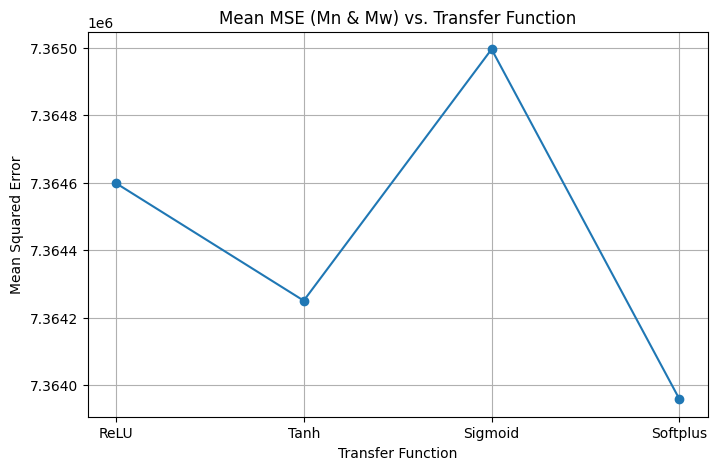

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

transfer_functions = {
    'relu': 'ReLU',
    'tanh': 'Tanh',
    'sigmoid': 'Sigmoid',
    'softplus': 'Softplus'
}

mse_results = []

for activation, name in transfer_functions.items():
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))
    model.add(Dense(16, activation=activation))
    model.add(Dropout(0.2))
    model.add(Dense(2, activation='tanh'))   # ⬅️ zwei Outputs: [Mn, Mw]
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, batch_size=4, epochs=50, verbose=0)
    y_pred = model.predict(X_test, verbose=0)  # Form (n,2)
    # Durchschnitts-MSE über beide Outputs (Mn & Mw)
    mse = mean_squared_error(y_test, y_pred)   # = uniform_average
    mse_results.append(mse)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(list(transfer_functions.values()), mse_results, marker='o', linestyle='-')
plt.title('Mean MSE (Mn & Mw) vs. Transfer Function')
plt.xlabel('Transfer Function')
plt.ylabel('Mean Squared Error')
plt.grid(True)
plt.show()